In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from keras.layers import Dropout
import warnings
warnings.filterwarnings("ignore")
import h5py

In [2]:
f = h5py.File('dataset_rsrp.h5', 'r')
with h5py.File('dataset_rsrp.h5', 'r') as f: 
    rsrp = np.array(f['RSRP_cell'])

In [118]:
# Base station
bs = 1
# Number of time instants that will be predicted
output = 300
# Number of time instants that will be stored
input = 500
# Time from where predictions will begin to be made
t = 100000 + input # predictions will be performed from (t-input) to (t)

n_features = 1
epochs = 2

In [119]:
model = Sequential()
model.add(GRU(input+64, activation='relu', input_shape=(output, n_features)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')    

In [120]:
# Starting a matrix with the predicted values to be stored
predicted_values = [0] * output
                                
# data
out_array = rsrp[1,(t-input):(t+output)].reshape(-1,1)
df = pd.DataFrame({'RSRP': list(out_array)}, columns=['RSRP'])
                                
#split data
train, test = df[:-output], df[-output:]

# scaling data 
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

# TS generator 
generator = TimeseriesGenerator(train, train, length = output, batch_size = 7)

# Model training 
model = model
model.fit_generator(generator, epochs = epochs)

# Model prediction 
pred_list = []

batch = train[-output:].reshape((1, output, n_features))

for i in range(output):
        pred_list.append(model.predict(batch)[0]) 
        # Storing the last predicted value in the matrix
        batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

# Model prediction: a new DF is created to save the prediction in their real scale
df_predict = scaler.inverse_transform(pred_list)
predicted_values[:] = df_predict

                      RSRP
0     [-107.7078349580585]
1    [-107.76355147231743]
2    [-107.82088653375163]
3    [-107.89332484507692]
4    [-107.97300394846232]
..                     ...
495  [-107.86130249518949]
496  [-107.90281338741572]
497  [-107.94318031016654]
498  [-107.99220044824301]
499  [-108.05284088944093]

[500 rows x 1 columns]
                      RSRP
500  [-108.09909426248998]
501  [-108.12421858668942]
502  [-108.12999276881393]
503  [-108.11014867446353]
504  [-108.07219360897668]
..                     ...
795  [-108.02603202489419]
796  [-107.96210344797477]
797  [-107.88486830086231]
798  [-107.82160770125984]
799   [-107.7792846498291]

[300 rows x 1 columns]
Epoch 1/2
29/29 [==============================] - 176s 6s/step - loss: 0.0829
Epoch 2/2
29/29 [==============================] - 158s 5s/step - loss: 0.0333


In [121]:
# Storing the real values in a matrix
real_values = [0] * output
for i in range(output):
        real_values[i] = rsrp[bs, t+output+i]

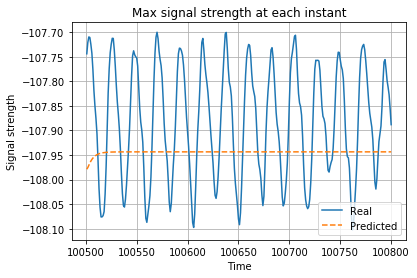

In [122]:
plt.figure()
plt.title('Max signal strength at each instant')
plt.xlabel('Time')
plt.ylabel('Signal strength')
# Plotting the original values
plt.plot(np.arange(t+1, t+output+1), real_values, label = 'Real')
# Plotting the prediction values
plt.plot(np.arange(t+1, t+output+1), predicted_values, label = 'Predicted', linestyle='dashed')
plt.grid()
plt.legend()
plt.show()